# NEURON Tutorial 3
## Objectives
- Load an biological detailed neuron from external *.hoc files.
- Simulation the imported neuron.


In [1]:
from neuron import h
from neuron.units import ms, mV 
import matplotlib.pyplot as plt
import numpy as np

**Note**: To use the user-defined biophysical mechanism, you need to compile `*.mod` files with `nrnivmodl` first. (For windows user, you may use `mknrndll` to compile the `*.mod` file).
```shell
cd E-I-Integration
nrnivmodl
```
The code above will created a nested folder, named `x86_64`, which containing the contained library files for user-defined modules.

*Reference*: https://senselab.med.yale.edu/ModelDB/NEURON_DwnldGuide

In [2]:
import neuron
neuron.load_mechanisms('./E-I-Integration/')

True

In [3]:
h.load_file('E-I-Integration/preload_files.hoc')

	1 
Check neuron_morph
	 Note: diam values less than 0.3um are set to 0.3um!
Diam was changed for: 0  points

	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 


1.0

In [4]:
# Parameters 

celsius = 34.0

Rm =  6e4
RmEnd = 2e4
RmSoma = Rm
RmAx = Rm

Cm   = 1

RaAll = 80

Vrest = -70

gna = 0.03

gkdr = 0.005

gka = 0.005
gka_dist = gka
gka_prox = gka

ghd = 2e-5
gh_soma = ghd
gh_end  = 10*ghd

gabab_gabaa_ratio = 0.6
nmda_ampa_ratio = 0.6   # to be reset in the main() function
Block_NMDA_Flag = False

In [5]:
# initial biophysical mechanisms
h.distance()
h.soma.insert('na3')
h.soma.insert('kdr')
h.soma.insert('hd')
h.soma.insert('kap')
h.soma.insert('pas')
h.soma.gbar_na3 = gna
h.soma.gkdrbar_kdr = gkdr
h.soma.ghdbar_hd = gh_soma
h.soma.vhalfl_hd = -73
h.soma.gkabar_kap = gka_prox
h.soma.e_pas = Vrest
h.soma.g_pas = 1/RmSoma 
h.soma.Ra = RaAll
h.soma.cm = Cm
  
for sec in h.axon_sections:
  sec.insert('nax')
  sec.insert('kdr')
  sec.insert('kap')
  sec.insert('pas')
  sec.gbar_nax = 2*gna
  sec.gkdrbar_kdr = gkdr
  sec.gkabar_kap = gka_prox
  sec.e_pas = Vrest 
  sec.g_pas = 1/RmAx 
  sec.Ra = RaAll 
  sec.cm = Cm

for sec in h.basal_dendrite:
  sec.insert('na3')
  sec.insert('kdr')
  sec.insert('kap')
  sec.insert('pas')
  sec.gbar_na3 = gna
  sec.gkdrbar_kdr = gkdr
  sec.gkabar_kap = gka_prox
  sec.e_pas = Vrest 
  sec.g_pas = 1/Rm 
  sec.Ra = RaAll 
  sec.cm = Cm

for sec in h.apical_dendrite:
  sec.insert('pas')
  sec.insert('na3')
  sec.insert('kdr')
  sec.e_pas = Vrest 
  sec.Ra = RaAll  
  sec.cm = Cm
  sec.gbar_na3 = gna
  sec.gkdrbar_kdr = gkdr
  sec.insert('hd')
  sec.insert('kap')
  sec.insert('kad')
  for seg in sec.allseg():
    if seg.x>0 and seg.x<1:
      xdist = h.distance(seg.x, sec=sec)

      rm = RmSoma + (RmEnd - RmSoma)/(1.0 + np.exp((300-xdist)/50))
      seg.g_pas = 1.0/rm

      seg.ghdbar_hd = gh_soma + (gh_end - gh_soma)/(1.0 + np.exp((300-xdist)/50)) #7 fold when xdist=335
      if xdist < 100:
        vhalfl_hd = -73
      else:
        vhalfl_hd = -81

      if xdist > 300:
        seg.ar2_na3 = 0.3
      else:
        seg.ar2_na3 = 0.9 - xdist*(0.9-0.3)/300

      if xdist < 100:
        seg.gkabar_kad = 0
        seg.gkabar_kap = gka_prox*(1+xdist/70)
      elif xdist < 350:
        seg.gkabar_kap = 0
        seg.gkabar_kad = gka_dist*(1+xdist/70)  #6 fold when xdist=350
      else:
        seg.gkabar_kap = 0
        seg.gkabar_kad = gka_dist*6


/Users/kchen/miniconda3/envs/bmtk/lib/python3.7/site-packages/neuron/__init__.py:873: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  line, = self.plot(xs, ys, zs, '-', **kwargs)


<neuron._PlotShapePlot.__call__.<locals>._get_pyplot_axis3d.<locals>.Axis3DWithNEURON at 0x7fb0802979d0>

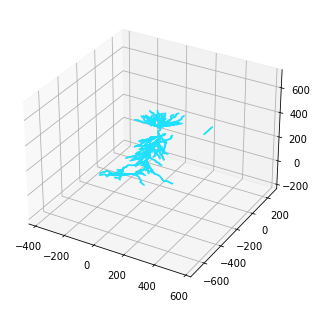

In [6]:
h.PlotShape(False).plot(plt)

from neuron import gui
ps = h.PlotShape(True)

### Define monitor

In [7]:
soma_v = h.Vector().record(h.soma(0)._ref_v)
t = h.Vector().record(h._ref_t)

### Initialize membrane potential and current

In [8]:
for sec in h.allsec():
  if h.ismembrane('na3', sec=sec) or h.ismembrane('nax'):
    sec.ena=55
  if h.ismembrane('kap', sec=sec) or h.ismembrane('kad', sec=sec) or h.ismembrane('kdr', sec=sec):
    sec.ek=-90
  #if h.ismembrane('hd', sec=sec):
  #  sec.ehd_hd=-30
h.finitialize(Vrest)
h.fcurrent()

for sec in h.allsec():
  for seg in sec.allseg():
    if h.ismembrane('na_ion', sec=sec) or h.ismembrane('k_ion', sec=sec):
      seg.e_pas=seg.v+(seg.ina+seg.ik)/seg.g_pas
    if h.ismembrane('hd', sec=sec):
      seg.e_pas = seg.e_pas + seg.i_hd/seg.g_pas
  h.fcurrent()

### Define synaptic input and synapses

In [9]:
I_loc=2
E_loc=28
stim_gaba=h.NetStim(0.5)
stim_gaba.number=1
stim_glut=h.NetStim(0.5)
stim_glut.number=1

In [10]:
sec = h.dend[I_loc]
syn_gaba_a = h.ExpSyn(sec(0.5))
syn_gaba_b = h.ExpSyn(sec(0.5))
syn_gaba_a.e=-80 * mV
syn_gaba_b.e=-80 * mV
  
sec = h.dend[E_loc]
E_dist = h.distance(0.5, sec=sec)
syn_ampa = h.ExpSyn(sec(0.5))
syn_nmda = h.ExpSyn(sec(0.5))
syn_ampa.e=0 * mV
syn_nmda.e=0 * mV
if not Block_NMDA_Flag:
  nmda_ampa_ratio = 0.6/(1+E_dist/300)
else:
  nmda_ampa_ratio = 0.1*0.6/(1+E_dist/300)
  
ncgabaa = h.NetCon(stim_gaba, syn_gaba_a)
ncgabab = h.NetCon(stim_gaba, syn_gaba_b)
ncgabaa.weight[0]= 2.0
ncgabab.weight[0]=ncgabaa.weight[0]*gabab_gabaa_ratio
ncnmda = h.NetCon(stim_glut, syn_nmda)
ncampa = h.NetCon(stim_glut, syn_ampa)
ncampa.weight[0] = 1.5 # (umho)   maximum conductance
ncnmda.weight[0] = ncampa.weight[0]*nmda_ampa_ratio

## Simulation

In [11]:
stim_gaba.start=20
stim_glut.start=100

h.finitialize(Vrest)
h.continuerun(200)

0.0

## Plotting

Text(0, 0.5, 'v (mV)')

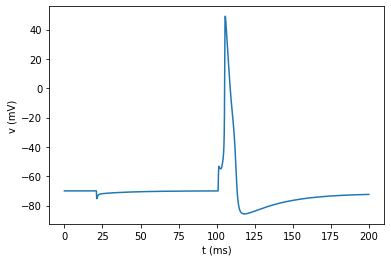

In [12]:
fig = plt.figure()
plt.plot(t, soma_v)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')